In [1]:
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
import os

from main import *
from model import *

%load_ext autoreload
%autoreload 2

In [2]:
data = np.load(f"lego_200x200.npz")

# Training images: [100, 200, 200, 3]
images_train = data["images_train"] / 255.0

# Cameras for the training images 
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = data["c2ws_train"]

# Validation images: 
images_val = data["images_val"] / 255.0

# Cameras for the validation images: [10, 4, 4]
# (camera-to-world transformation matrix): [10, 200, 200, 3]
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering: 
# (camera-to-world transformation matrix): [60, 4, 4]
c2ws_test = data["c2ws_test"]

# Camera focal length
focal = data["focal"]  # float

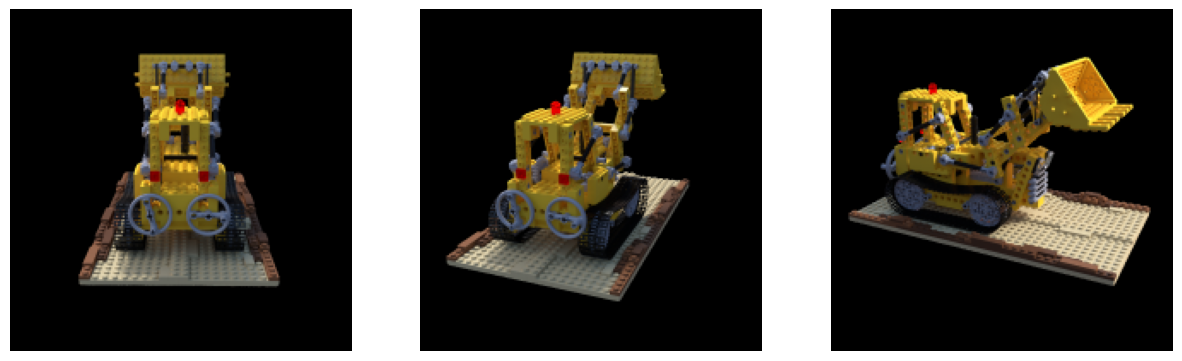

In [3]:
# show 2-3 random images
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].imshow(images_train[i])
    ax[i].axis('off')

In [4]:
batch_size = 10_000
train_dataset = RayDataset(images_train, c2ws_train, focal)
val_dataset = RayDataset(images_val, c2ws_val, focal)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
model = Net3d(device)
print(model)

63 27
Net3d(
  (pe_x): PositionalEncoding()
  (pe_rd): PositionalEncoding()
  (mlp1): Sequential(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
  )
  (mlp2): Sequential(
    (0): Linear(in_features=319, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
  )
  (density_head): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): ReLU()
  )
  (pre_mix_head): Linear(in_features=256, out_features=256, bias=True)
  (color_head): Sequential(
    (0): Linear(in_features=283, out_features=128, bias=

In [7]:
loss_fn = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [10]:
rays_o, rays_d, rgb_gt = train_dataset.sample_rays(batch_size)
rays_o.shape, rays_d.shape, rgb_gt.shape

(torch.Size([10000, 3]), torch.Size([10000, 3]), torch.Size([10000, 3]))

In [11]:
x = train_dataset.sample_along_rays(rays_o, rays_d)
x.shape

torch.Size([10000, 64, 3])

In [13]:
loss_list = []
PSNR_list = []

def train(model, loss_fn, optimizer):
    
    for i in tqdm(range(len(train_dataset) // batch_size)):
        rays_o, rays_d, rgb_gt = train_dataset.sample_rays(batch_size)
        x = train_dataset.sample_along_rays(rays_o, rays_d) # N x n_samples x 3
        
        optimizer.zero_grad()
        rgb_pred = model(x, rays_d)

        loss = loss_fn(rgb_pred, rgb_gt.to(device))
        loss_list.append(loss.item())
        PSNR_list.append(PSNR(loss).item())

        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f'Batch {i}, Loss: {loss.item()}, PSNR: {PSNR(loss).item()}')

In [14]:
epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(model, loss_fn, optimizer)

Epoch 1
-------------------------------


  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 1/400 [00:52<5:48:07, 52.35s/it]

Batch 0, Loss: 28.529281616210938, PSNR: -14.552907943725586


  0%|          | 1/400 [01:00<6:40:43, 60.26s/it]


KeyboardInterrupt: 